In [24]:
#imports
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os
import json
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import tensorflow as tf
import autokeras as ak
#load data
from BIAS.SB_Test_runner import get_scens_per_dim, get_simulated_data

class newmodel(MLPClassifier):
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        y = self.model.predict(X)
        return np.argmax(y, axis=1)


## Settings for this experiment

20000 repetitions per class (group of scenes) and 500 samples (runs)

In [25]:
#settings for this experiment
rep = 20000
n_samples = 500

## Loading the data

In [26]:
#load data
scenes = get_scens_per_dim()
per_label = {"unif":0, "centre":0, "bounds":0, "gaps/clusters":0, "disc":0}
X = []
y = []
realY = []
for scene in scenes:
    label = scene[0]
    realLabel = f"{label} " + json.dumps(scene[1])
    kwargs = scene[1]
    if (label == "unif"):
        rep1 = 4 * rep
    elif (label in ["trunc_unif", "cauchy", "norm"]):
        rep1 = int(rep / 32)
    elif (label in ["bound_thing","inv_norm", "inv_cauchy"]):
        rep1 = int(rep / 48)
    elif (label in ["clusters","gaps", "part_unif"]):
        rep1 = int(rep / 67)
    elif (label in ["spikes", "shifted_spikes"]):
        rep1 = int(rep / 42)
    data = get_simulated_data(label, rep=rep1, n_samples = n_samples, kwargs=kwargs)
    for r in range(rep1):
        X.append(np.sort(data[:,r]))
    if (label in ["trunc_unif", "cauchy", "norm"]):
        label = "centre"
    elif (label in ["bound_thing","inv_norm", "inv_cauchy"]):
        label = "bounds"
    elif (label in ["gaps", "part_unif", "clusters"]):
        label = "gaps/clusters"
    elif (label in ["spikes", "shifted_spikes"]):
        label = "disc"
    per_label[label] += rep1
    y.extend([label]*rep1)
    realY.extend([realLabel] * rep1)

print(per_label)
X = np.array(X)
int_y, targetnames= pd.factorize(y)
int_real_y, targetnames_real= pd.factorize(realY)

cat_y = to_categorical(int_y)
cat_y_real = to_categorical(int_real_y)

X_train, X_test, y_train, y_test = train_test_split(X, cat_y, test_size=0.2, random_state=42, stratify=int_y)
# use same random seed to get the real labels
_, __, y_train_real, y_test_real = train_test_split(X, cat_y_real, test_size=0.2, random_state=42, stratify=int_y)

#retransform y_test_real
y_test_real_num = np.argmax(y_test_real, axis=1)
y_test_real_names = targetnames_real[y_test_real_num]
print(y_test_real_names)

#expand dims
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

{'unif': 80000, 'centre': 20000, 'bounds': 19968, 'gaps/clusters': 19966, 'disc': 19992}
['unif {}' 'unif {}' 'unif {}' ... 'unif {}' 'unif {}'
 'norm {"sigma": 0.1, "mu": 0.6}']


## Loading the model from h5 file

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 1)]          0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 500, 1)           0         
 t32)                                                            
                                                                 
 expand_last_dim (ExpandLast  (None, 500, 1, 1)        0         
 Dim)                                                            
                                                                 
 normalization (Normalizatio  (None, 500, 1, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 500, 1, 64)        3200      
                                                             

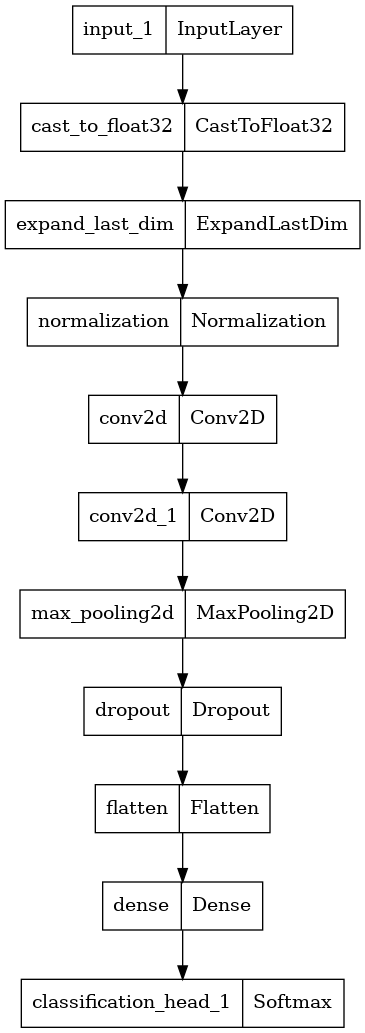

In [27]:
#load model
model = tf.keras.models.load_model(f"opt_cnn_model-{n_samples}.h5")
model.summary()
print(
    "Accuracy: {accuracy}".format(
        accuracy = model.evaluate(x=X_test, y=y_test)
    )
)
tf.keras.utils.plot_model(model, to_file=f"opt_cnn_model-{n_samples}.png")

## Analysis of wrongly predicted cases in the test data

In [58]:
model1 = newmodel(model)
hat_y = model1.predict(X_test)

hat_y_real = model.predict(X_test)

1000/1000 [==============================] - 6s 6ms/step


In [ ]:
#analyse
import seaborn as sbs


test_y = np.argmax(y_test, axis=1)
for i in range(len(hat_y)):
    if hat_y[i] != test_y[i]:
        fig, axs = plt.subplots(1, figsize=(3,8))
        sbs.swarmplot(data=X_test[i].flatten(), ax=axs, size=2)
        plt.title(f"Prediction: {targetnames[hat_y[i]]} \n True label: {targetnames[test_y[i]]}")
        #plt.show()
        plt.tight_layout()
        plt.savefig(f"misclasifications/prediction{i}.png")

## Compute shap values for all test cases

In [37]:
#using shap
import shap
# select backgroud for shap
background = X_train[np.random.choice(X_train.shape[0], 1000, replace=False)]
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)
# compute shap values

#different try
#bg = shap.maskers.Partition(shap.utils.sample(X,100))
#explainer = shap.explainers.Partition(f, bg)

x_explained = X_test[:100]
shap_values = explainer.shap_values(x_explained)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [38]:
np.array(shap_values).shape

(5, 100, 500, 1)

In [63]:
#plot shap explanations
from matplotlib.gridspec import GridSpec
def plot_explanation(x, preds, pred_labels, shap_vals_pred, shap_vals_true, prediction, label, filename):
    plt.ioff()
    cmap = sbs.color_palette('coolwarm', as_cmap=True)
    norm = plt.Normalize(vmin=-1*np.max(np.abs(shap_vals_pred)), vmax=np.max(np.abs(shap_vals_pred)))  # 0 and 1 are the defaults, but you can adapt these to fit other uses
    df = pd.DataFrame({"x": x.flatten(), "shap": shap_vals_pred.flatten()})
    palette = {h: cmap(norm(h)) for h in df['shap']}

    #fig, axs = plt.subplots(2, figsize=(8,2))
    fig = plt.figure(figsize=(8,4))
    gs = GridSpec(2, 3, figure=fig)
    ax1 = fig.add_subplot(gs[:, 0]) #prediction labels
    ax1.bar(pred_labels, preds)
    plt.xticks(rotation=30, ha='right')
    ax1.set_title("Prediction probabilities")
    ax1.set_ylim([0,1])

    ax2 = fig.add_subplot(gs[0, 1:])
    ax2.set_title(f"Predicted: {prediction}")
    sbs.swarmplot(data=df, x="x", hue="shap", palette=palette, ax=ax2, size=4, legend=False)
    ax2.set_xlabel("")
    ax2.set_xlim([0,1])

    cmap = sbs.color_palette('coolwarm', as_cmap=True)
    norm = plt.Normalize(vmin=-1*np.max(np.abs(shap_vals_true)), vmax=np.max(np.abs(shap_vals_true)))  # 0 and 1 are the defaults, but you can adapt these to fit other uses
    df = pd.DataFrame({"x": x.flatten(), "shap": shap_vals_true.flatten()})
    palette = {h: cmap(norm(h)) for h in df['shap']}
    ax3 = fig.add_subplot(gs[1, 1:])
    sbs.swarmplot(data=df, x="x", hue="shap", palette=palette, ax=ax3, size=4, legend=False)
    ax3.set_title(f"Label: {label}")
    ax3.set_xlabel("")
    ax3.set_xlim([0,1])
    
    #sbs.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

test_y = np.argmax(y_test, axis=1)
for i in range(len(hat_y)):
    if hat_y[i] != test_y[i] and targetnames[test_y[i]] == "unif":
        shap_val = explainer.shap_values(X_test[i:i+1])
        plot_explanation(X_test[i], 
            hat_y_real[i], 
            targetnames,
            shap_val[hat_y[i]][0], 
            shap_val[test_y[i]][0], 
            targetnames[hat_y[i]], 
            targetnames[test_y[i]], 
            f"misclasifications-unif/prediction{i}.png")



KeyboardInterrupt: 

## Plot confusion matrix

In [64]:
#plot confusion matrix
fig, ax = plt.subplots(figsize=(14, 14))
plot_confusion_matrix(model1, X_test, test_y, normalize='true', xticks_rotation = 'vertical', display_labels = targetnames, ax=ax) 
plt.savefig(f"opt_cnn_model-{n_samples}-confusion.png")
#plt.show()

   9/1000 [..............................] - ETA: 6s 

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


1000/1000 [==============================] - 6s 6ms/step


: 